In [2]:
import pandas as pd
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix
import pyranges as pr
import subprocess

In [3]:
dry = False

if dry == True:
    wgbs_bed_path = './test_data/mm39_ENCSR893RHD_modifications_mergeDups_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/mm39_ENCSR893RHD_merged.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

In [3]:
def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "readCount", "modification_type"]), [bis_df, nano_df])
    wide_merged = pd.merge(
        bis_df, nano_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_Bisulphite", "_Nanopore"]
        )
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd"], 
                                  j="method", sep="_", suffix="\D+")
    return wide_merged.reset_index(drop=True), long_merged.reset_index()

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)

def calcKS(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.ks_2samp(x, y, method="asymp")

In [4]:
two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)

# Locus level epigenetic analysis

These figures compare modified based detection at individual CpG dinucleotide loci. 

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


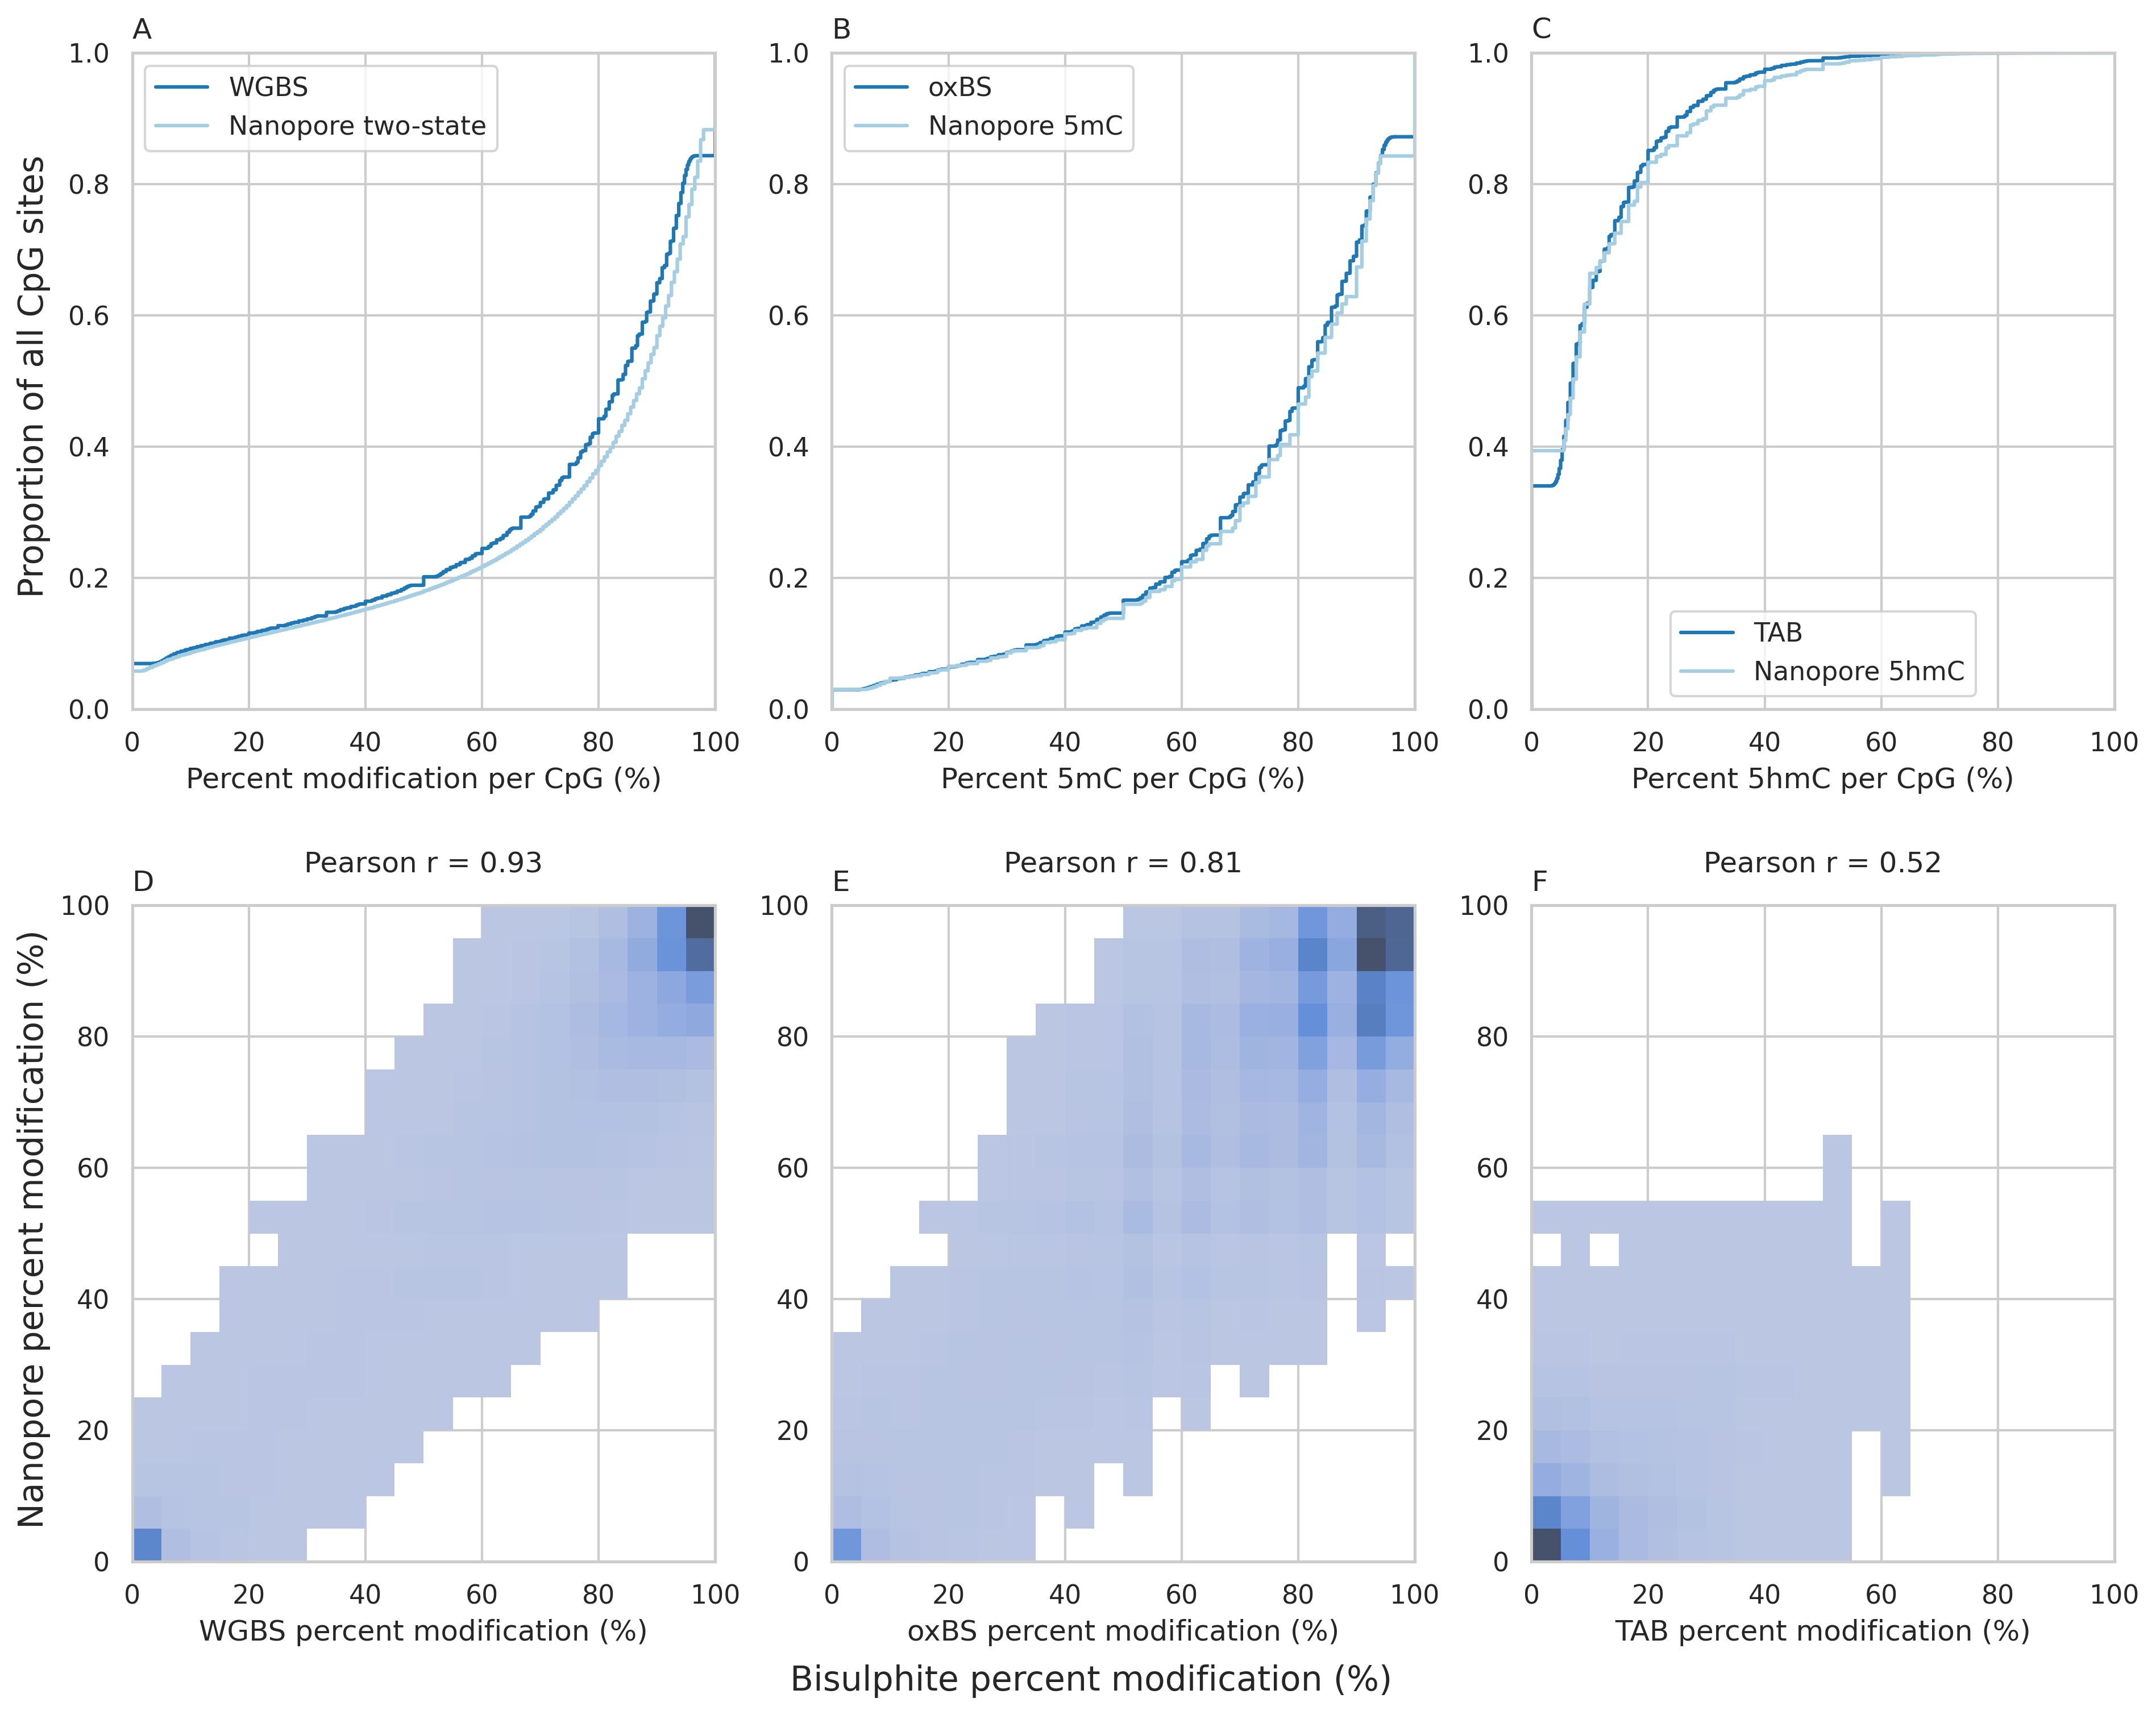

In [123]:
sns.set_theme(style="whitegrid")

fig1 = plt.figure(dpi=300, figsize=(15, 10)) 
gs1 = GridSpec(2, 1, fig1)

fig11 = fig1.add_subfigure(gs1[0, :])
gs11 = GridSpec(1, 3, fig11)
fig11.supylabel("Proportion of all CpG sites", x=0.08)

ax11 = fig11.add_subplot(gs11[0, 0])
ax12 = fig11.add_subplot(gs11[0, 1])
ax13 = fig11.add_subplot(gs11[0, 2])

sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", palette="Paired", ax=ax11)
sns.move_legend(ax11, "upper left", title=None, labels=["WGBS", "Nanopore two-state"])
# ax11.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(two_mod_wide)[0]), ha="center")
ax11.set_ylabel(None)
ax11.set_xlabel("Percent modification per CpG (%)")
ax11.set_title("A", loc="left")
ax11.set_xlim([0, 100])

sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax12)
sns.move_legend(ax12, "upper left", title=None, labels=["oxBS", "Nanopore 5mC"])
# ax12.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(mc_df_wide)[0]), ha="center")
ax12.set_ylabel(None)
ax12.set_xlabel("Percent 5mC per CpG (%)")
ax12.set_title("B", loc="left")
ax12.set_xlim([0, 100])

sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax13)
sns.move_legend(ax13, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
# ax13.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(hmc_df_wide)[0]), ha="center")
ax13.set_ylabel(None)
ax13.set_xlabel("Percent 5hmC per CpG (%)")
ax13.set_xlim([0, 100])
ax13.set_title("C", loc="left")

fig12 = fig1.add_subfigure(gs1[1, :])
fig12.supxlabel("Bisulphite percent modification (%)", y=-0.05)
fig12.supylabel("Nanopore percent modification (%)", x=0.08)
gs12 = GridSpec(1, 3, fig12)

ax14 = fig12.add_subplot(gs12[0, 0])
ax15 = fig12.add_subplot(gs12[0, 1])
ax16 = fig12.add_subplot(gs12[0, 2])

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax14)
ax14.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax14.set_xlim((0, 100))
ax14.set_ylim((0, 100))
ax14.set_xlabel("WGBS percent modification (%)")
ax14.set_ylabel(None)
ax14.set_title("D", loc="left")

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax15)
ax15.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax15.set_xlim((0, 100))
ax15.set_ylim((0, 100))
ax15.set_xlabel("oxBS percent modification (%)")
ax15.set_ylabel(None)
ax15.set_title("E", loc="left")

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax16)
ax16.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax16.set_xlim((0, 100))
ax16.set_ylim((0, 100))
ax16.set_xlabel("TAB percent modification (%)")
ax16.set_ylabel(None)
ax16.set_title("F", loc="left")

fig1.show()

In [5]:
def ROCmain(wide_df, ax, label):

    def ROCbinariser():
        binariser = preprocessing.Binarizer(threshold=50)
        wide_df["binarised"] = binariser.fit_transform(np.reshape(wide_df["percentMeth_Bisulphite"].to_numpy(), (-1, 1)))
        return wide_df

    def ROC():
        binarised_df = ROCbinariser()
        fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])
        return fpr, tpr
    
    def plotROC(ax, label):
        fpr, tpr = ROC()
        return ax.plot(fpr, tpr, "-", label=label, lw=2)

    return plotROC(ax, label)

def merge3Mod(): 
    merged_df = pd.merge(mc_df_wide, hmc_df_wide, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [merge3Mod()["percentMeth_Bisulphite_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Bisulphite_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [merge3Mod()["percentMeth_Nanopore_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

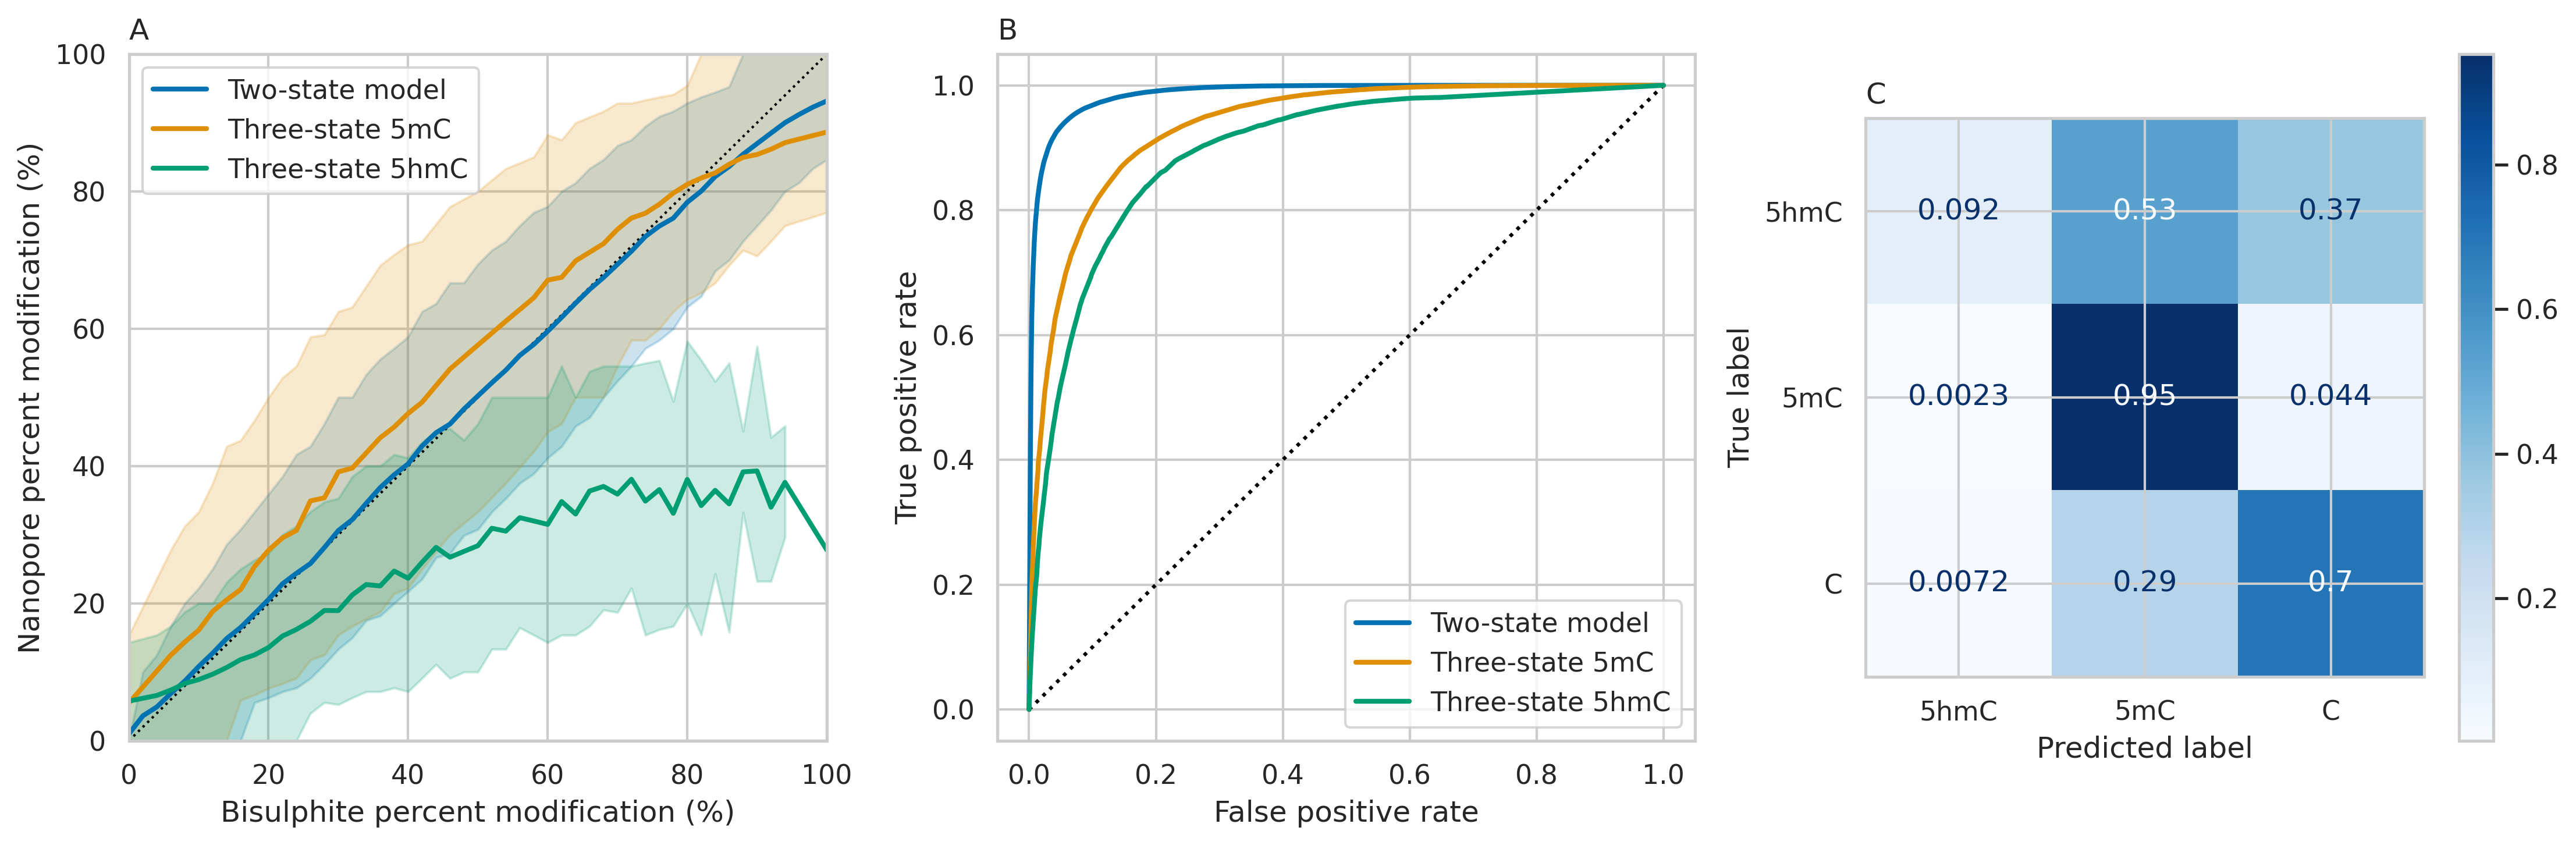

In [6]:
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = plt.figure(dpi=300, figsize=(15, 5)) 
gs2 = GridSpec(1, 3, fig2)

ax21 = fig2.add_subplot(gs2[0, 0])
ax21.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(two_mod_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Two-state model", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(mc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5mC", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5hmC", linewidth=2, ax=ax21)
ax21.legend()
sns.move_legend(ax21, "upper left")
ax21.set_ylim((0, 100))
ax21.set_xlim((0, 100))
ax21.set_xlabel("Bisulphite percent modification (%)")
ax21.set_ylabel("Nanopore percent modification (%)")
ax21.set_title("A", loc="left")

ax24 = fig2.add_subplot(gs2[0, 1])
ax24.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")
ROCmain(two_mod_wide, ax24, "Two-state model")
ROCmain(mc_df_wide, ax24, "Three-state 5mC")
ROCmain(hmc_df_wide, ax24, "Three-state 5hmC")
ax24.set_xlabel("False positive rate")
ax24.set_ylabel("True positive rate")
ax24.legend()
sns.move_legend(ax24, "lower right")
ax24.set_title("B", loc="left")

ax25 = fig2.add_subplot(gs2[0, 2])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax25)
ax25.set_title("C", loc="left")

fig2.tight_layout()

# Macro-scale 5hmC analysis

These figures compare 5hmC calling at the level of larger elements, including whole genes and 1kb windows. The focus of these images is on 5hmC - given that this is the modified base with lower apparent classification agreement (see above)

In [7]:
def threeModDFtoPyrange():
    data = merge3Mod()

    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand_5hmC"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange
    
three_mod_pr = threeModDFtoPyrange()

In [8]:
def singleFeatureName(path):
    
    first_line = checkFirstLine(path)
    
    if len(first_line.split("\t")) == 5:
        names=["Chromosome", "Start", "End", "Name", "Strand"]
    elif len(first_line.split("\t")) == 6:
        names=["Chromosome", "Start", "End", "Name", "Score", "Strand"]
    else:
        raise ValueError("Please check number of columns in file. Must equal 5 or 6.")
    
    bed_file = pd.read_csv(path, sep="\t", names=names)
    bed_file["Name"] = bed_file["Name"].apply(lambda names: names.split(",").pop(0))

    file_name = "/".join(path.split("/")[0:4]) + "/name_adjusted/" + path.split("/")[4]
    
    bed_file.to_csv(file_name, "\t", header=False, index_label=None, index=False)
    return 
    
directory_list = subprocess.check_output(["ls", "./feature_references/revised/gene_features/"]).decode("utf-8").split("\n")[0:8]

for name in directory_list:
    name = "./feature_references/revised/gene_features/" + name
    try:
        singleFeatureName(name)
    except ValueError:
        continue

NameError: name 'checkFirstLine' is not defined

In [161]:
class refTSV:
    """
    Superclass of tab-separated (incl. bed) files used for feature alignment. 
    """
    def __init__(self, path):
        self.path = path
    
    def checkNumColumns(self):
        """
        Checks and returns the number of columns present in the TSV file.
        """
        first_line = subprocess.check_output(["head", "-n 1", f"{self.path}"]).decode("utf-8")
        num_columns = len(first_line.split("\t"))

        return num_columns
    
    def getColNames(self):
        """
        Uses the number of columns to predict column name labels. 
        """
        names = ["Chromosome", "Start", "End"]
        return names
    
    def getFirstLine(self):
        first_line = subprocess.check_output(["head", "-n 1", f"{self.path}"]).decode("utf-8").split("\t")
        return first_line
    
class featureTSV(refTSV):
    """
    Regularly used file type containing information about genomic features. Columns must contain follow BED 'Chromosome', 'Start', 'End', 'Name' format. 
    """

    def __init__(self, path):
        super().__init__(path)
   
    def getColNames(self):
        """
        Uses the number of columns to predict column name labels. 
        """
        col_length = super().checkNumColumns()
        names =  super().getColNames()
        
        if col_length == 4:
            names.extend(["Name"])
        elif col_length == 5:
            names.extend(["Name", "Strand"])
        elif col_length == 6:
            names.extend(["Name", "Score", "Strand"])
        else:
            raise ValueError("Please check number of columns in file. Must equal 4, 5, or 6.")
        return names
    
    def retrieveFeatureType(self):
        """
        Uses the file extension to determine the type of feature. File must be saved in a './1_2_3_feature-type_4.bed' fashion. 
        """
        filename = self.path.split("/").pop(-1)
        feature_type = filename.split("_").pop(3)

        return feature_type
    
    def toDF(self):
        """
        Shows the feature file as a pandas DataFrame.
        """
        df = pd.read_csv(self.path, sep="\t", names=self.getColNames())
        df["feature_type"] = self.retrieveFeatureType()
        
        return df

class cgiTSV(refTSV):
    """
    Subclass of reference tab-separated variable file containing information about CpG island positions. file
    """
    def __init__(self, path):
        self.path = path

    def retrieveFeatureType(self):
        first_line = super().getFirstLine()
        
        return first_line[-1].strip("\n")
    
    def getColNames(self):
        """
        Uses the number of columns to predict column name labels. 
        """
        col_length = super().checkNumColumns()
        names =  super().getColNames()
        first_line = super().getFirstLine()

        if first_line[3].__contains__("CpG"):
            names.extend(["NCpGs", "feature_type"])
        else:
            names.extend(["Name", "feature_type"])
        
        return names
    
    def toDF(self):
        """
        Shows the feature file as a pandas DataFrame.
        """
        df = pd.read_csv(self.path, sep="\t", names=self.getColNames())
        
        return df
    

In [178]:
def makeFeatureRefDF():
    gene_feature_list = subprocess.check_output(["ls", "./feature_references/revised/gene_features/name_adjusted/"]).decode("utf-8").split("\n") 
    gene_feature_list.pop(-1)

    df_list = []
    for file in gene_feature_list:
        path = "./feature_references/revised/gene_features/name_adjusted/" + file
        feature_tsv = featureTSV(path)
        feature_df = feature_tsv.toDF()
        df_list.append(feature_df)

    feature_reference_df = pd.concat(df_list)
    return feature_reference_df.drop(columns=["Score"])

def makeCGIrefDF():
    cgi_feature_list = subprocess.check_output(["ls", "./feature_references/revised/cgi/"]).decode("utf-8").split("\n") 
    cgi_feature_list.pop(-1)

    cgi_df_list = []
    for file in cgi_feature_list:
        path = "./feature_references/revised/cgi/" + file
        cgi_tsv = cgiTSV(path)
        cgi_df = cgi_tsv.toDF()
        cgi_df_list.append(cgi_df)

    cgi_reference_df = pd.concat(cgi_df_list)
    return cgi_reference_df

In [182]:
def intersectWithGene():
    pyrange = three_mod_pr
    gene_ref = pd.read_csv('./feature_references/revised/GENCODE_Basic_mm39_Genes_merged.bed', sep="\t", 
                           names=["Chromosome", "Start", "End", "geneName", "Strand"])    
    return pyrange.join(pr.PyRanges(gene_ref), strandedness="same")

def convertToGeneDF():
    pyrange = intersectWithGene()
    gene_df = pyrange.as_df().groupby(["geneName"])[["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"]].agg([np.mean, "count"])
    return gene_df.reset_index()

def geneLog2MeanDF():
    gene_df = convertToGeneDF()
    nanopore_mean = np.mean(gene_df["percentMeth_Nanopore_5hmC"]["mean"])
    bisulphite_mean = np.mean(gene_df["percentMeth_Bisulphite_5hmC"]["mean"])

    with np.errstate(divide="ignore"):
        gene_df["Log2FromMean_Nanopore"] = np.log2(
            np.divide(gene_df["percentMeth_Nanopore_5hmC"]["mean"],
                    nanopore_mean)
        )
        gene_df["Log2FromMean_Bisulphite"] = np.log2(
            np.divide(gene_df["percentMeth_Bisulphite_5hmC"]["mean"],
                    bisulphite_mean)
        )
    gene_df = gene_df.replace(-np.inf, np.nan)
    return gene_df.dropna()    

def makeRefDF(path, feature_type):
    columns = ["Chromosome","Start","End","Name","Score","Strand","feature_type"]
    df = pd.read_csv(path, sep="\t", names=columns)
    df["feature_type"] = feature_type
    return df

def meltMethod(input_df):
    df_melt = input_df.melt(
        ["Chromosome", "Start", "End", "Strand", "feature_type", "Name"], 
        ["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], 
        "method", 
        value_name="percentMeth"
                    )
    return df_melt

def replaceMethod(input_df):
    df_with_replacement = input_df.replace(["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], ["Nanopore 5hmC", "TAB"])
    return df_with_replacement

def categoriseGeneFeatures(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], 
        ["Intergenic", "Promoter", "5UTR", "TSS", "Intron", "Exon", "3UTR", "TTS"])
    return categorised_features
        
def categoriseCGI(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"])
    return categorised_features
        
def intersectWithFeatures(input_df, categorise=None):

    if categorise == "Gene features":
        ref_features = pr.PyRanges(makeFeatureRefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseGeneFeatures(feature_intersect_df)

    elif categorise == "CGI":
        ref_features = pr.PyRanges(makeCGIrefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseCGI(feature_intersect_df)
        
    return feature_intersect_df

def featureBarplotMain():
    input_df = three_mod_pr
    output_df = intersectWithFeatures(input_df, "Gene features")
    
    return output_df.groupby(["method", "feature_type", "Name"])["percentMeth"].mean().reset_index().dropna()

def cgiLinePlotMain():
    input_df = three_mod_pr
    output_df = intersectWithFeatures(input_df, "CGI")
    return output_df

def clusterPyrangeToDF(pyrange):
    tiled_pr = pyrange.tile(1000, strand=False).cluster(slack=-1, strand=False)
    cluster_pr = tiled_pr.merge(slack=-1, count=True, strand=False)
    cluster_pr = cluster_pr.insert(tiled_pr.apply(f=lambda df: df.groupby("Cluster")[["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"]].mean(), as_pyranges=False, strand=False))
    return cluster_pr.as_df()

def log2FromMean(df):
    nano_mean = np.mean(df["percentMeth_Nanopore_5hmC"])
    bisulphite_mean = np.mean(df["percentMeth_Bisulphite_5hmC"])

    with np.errstate(divide="ignore"):
        df["Log2FromMean_Bisulphite"], df["Log2FromMean_Nanopore"] = np.log2(np.divide(df["percentMeth_Bisulphite_5hmC"], bisulphite_mean)), np.log2(np.divide(df["percentMeth_Nanopore_5hmC"], nano_mean))

    return df.replace(-np.inf, np.nan).dropna()

def tileMain():
    return log2FromMean(clusterPyrangeToDF(three_mod_pr))

In [244]:
class validationDF:
    """
    Dataframes to be used in identifying target genes/regions for experimental validation. 
    """
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def methodComparison(self):
        """
        Adds "Average" and "Difference" to the dataframe, displaying the average level of enrichment and difference between method enrichment levels respectively.
        """
        df = self.dataframe

        df["Average"] = df[["Log2FromMean_Bisulphite", "Log2FromMean_Nanopore"]].mean(axis=1)
        df["Difference"] = np.subtract(df["Log2FromMean_Bisulphite"], df["Log2FromMean_Nanopore"])

        return df

    def positiveControlGroupDF(self, number_target_tiles):
        """
        Returns the positive control group - entries enriched in both methods.
        """
        df = self.methodComparison()
        df = df.nlargest(50, "Average")
        df = df.nsmallest(number_target_tiles, "Difference")
        return df
    
    def NegativeControlGroupDF(self, number_target_tiles):
        """
        Returns the negative control group - entries not enriched in either method.
        """
        df = self.methodComparison()
        df = df.nsmallest(50, "Average")
        df = df.nsmallest(number_target_tiles, "Difference")
        return df

    def NanoporePositiveGroupDF(self, number_target_tiles):
        """
        Returns the Nanopore positive test group - entries enriched only in Nanopore.
        """
        df = self.methodComparison()
        df = df.loc[df["Log2FromMean_Bisulphite"] <= 0]
        df = df.nlargest(number_target_tiles, "Log2FromMean_Nanopore")
        return df
    
    def TabPositiveGroupDF(self, number_target_tiles):
        """
        Returns the TAB positive test group - entries enriched only in TAB.
        """
        df = self.methodComparison()
        df = df = df.loc[df["Log2FromMean_Nanopore"] <= 0]
        df = df.nlargest(number_target_tiles, "Log2FromMean_Bisulphite")
        return df
        
    def makeHist(self, ax):
        """
        Produces a Seaborn histogram from the dataframe. 
        """
        hist = sns.histplot(self.dataframe, 
                         x="Log2FromMean_Bisulphite", 
                         y="Log2FromMean_Nanopore", 
                         cbar=True, stat="density", cbar_kws={"label" : "Bin density"}, ax=ax)
        return hist
    

In [ ]:
class validationDF:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def methodComparison(self):
        df = self.dataframe

        df["Average"] = df[["Log2FromMean_Bisulphite", "Log2FromMean_Nanopore"]].mean(axis=1)
        df["Difference"] = np.subtract(df["Log2FromMean_Bisulphite"], df["Log2FromMean_Nanopore"])

        return df

    def positiveControlGroupDF(self, number_target_tiles):
        df = self.methodComparison()
        df = df.nlargest(50, "Average")
        df = df.nsmallest(number_target_tiles, "Difference")
        return df
    
    def NegativeControlGroupDF(self, number_target_tiles):
        df = self.methodComparison()
        df = df.nsmallest(50, "Average")
        df = df.nsmallest(number_target_tiles, "Difference")
        return df

    def NanoporePositiveGroupDF(self, number_target_tiles):
        df = self.methodComparison()
        df = df.loc[df["Log2FromMean_Bisulphite"] <= 0]
        df = df.nlargest(number_target_tiles, "Log2FromMean_Nanopore")
        return df
    
    def TabPositiveGroupDF(self, number_target_tiles):
        df = self.methodComparison()
        df = df = df.loc[df["Log2FromMean_Nanopore"] <= 0]
        df = df.nlargest(number_target_tiles, "Log2FromMean_Bisulphite")
        return df
    
    def makeHist(self, ax):
        hist = sns.histplot(self.dataframe, 
                         x="Log2FromMean_Bisulphite", 
                         y="Log2FromMean_Nanopore", 
                         cbar=True, stat="density", cbar_kws={"label" : "Bin density"}, ax=ax)
        return hist
    

In [240]:
validationDF(tileMain()).positiveControlGroupDF(10)

,Chromosome,Start,End,Count,percentMeth_Nanopore_5hmC,percentMeth_Bisulphite_5hmC,Log2FromMean_Bisulphite,Log2FromMean_Nanopore,Average,Difference
39299,chr1,64075000,64076000,1,72.73,38.461538,2.076321,3.072399,2.574360,-0.996077
19524,chr1,34141000,34142000,1,78.57,50.000000,2.454833,3.183826,2.819330,-0.728994
12365,chr1,22788000,22789000,1,71.43,50.000000,2.454833,3.046378,2.750605,-0.591545
11155,chr1,21009000,21010000,1,60.00,50.000000,2.454833,2.794810,2.624822,-0.339978
13612,chr1,24588000,24589000,1,59.09,50.000000,2.454833,2.772762,2.613797,-0.317929
13120,chr1,23938000,23939000,1,70.59,63.157895,2.791868,3.029312,2.910590,-0.237444
36315,chr1,59824000,59825000,1,72.73,66.666667,2.869870,3.072399,2.971134,-0.202528
38608,chr1,62991000,62992000,1,66.67,61.538462,2.754393,2.946886,2.850639,-0.192493
21197,chr1,37342000,37343000,1,60.00,56.250000,2.624758,2.794810,2.709784,-0.170053
39353,chr1,64154000,64155000,2,55.59,53.947368,2.564457,2.684673,2.624565,-0.120216


In [184]:
tileMain()

,Chromosome,Start,End,Count,percentMeth_Nanopore_5hmC,percentMeth_Bisulphite_5hmC,Log2FromMean_Bisulphite,Log2FromMean_Nanopore
4,chr1,3082000,3083000,2,6.250,3.571429,-1.352522,-0.468224
5,chr1,3086000,3087000,4,6.250,2.272727,-2.004599,-0.468224
7,chr1,3091000,3092000,2,3.335,9.090909,-0.004599,-1.374393
21,chr1,3116000,3117000,2,6.070,5.263158,-0.793095,-0.510384
22,chr1,3117000,3118000,1,5.880,6.250000,-0.545167,-0.556264
...,...,...,...,...,...,...,...,...
45454,chr1,72592000,72593000,1,27.270,7.692308,-0.245607,1.657163
45457,chr1,72599000,72600000,3,23.280,17.777778,0.962980,1.428939
45459,chr1,72601000,72602000,2,3.570,10.238095,0.166852,-1.276156
45460,chr1,72602000,72603000,2,8.335,8.513932,-0.099198,-0.052898


In [186]:
gene_log2_mean_df = geneLog2MeanDF()

In [20]:
def geneTestGroupHelper():
    gene_df = gene_log2_mean_df.copy().sort_index(axis=1)
    gene_df["Count"] = gene_df["percentMeth_Bisulphite_5hmC"]["count"]
    gene_df["Difference"] = np.subtract(gene_df["Log2FromMean_Bisulphite"], gene_df["Log2FromMean_Nanopore"])
    gene_df["Average"] = gene_df[["Log2FromMean_Bisulphite", "Log2FromMean_Nanopore"]].mean(axis=1)
    # gene_df = gene_df.loc[gene_df["percentMeth_Bisulphite_5hmC"]["count"] > 20]
    return gene_df.drop(columns=["percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])

cpg_threshold = 25
number_target_genes = 10

def geneNegativeControl():
    df = geneTestGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.nsmallest(50, "Average")
    df = df.nsmallest(number_target_genes, "Difference")
    return df 

def genePositiveControl():
    df = geneTestGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.nlargest(50, "Average")
    df = df.nsmallest(number_target_genes, "Difference")
    return df 

def geneNanoporePositive():
    df = geneTestGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.loc[df["Log2FromMean_Bisulphite"] <= 0]
    df = df.nlargest(number_target_genes, "Log2FromMean_Nanopore")
    return df 

def geneTabPositive():
    df = geneTestGroupHelper()
    df = df.loc[df["Count"] >= cpg_threshold]
    df = df.loc[df["Log2FromMean_Nanopore"] <= 0]
    df = df.nlargest(number_target_genes, "Log2FromMean_Bisulphite")
    return df 

## Output list of possible target genes

In [74]:
import mygene
import openpyxl

def splitENSIDSeries(df):
    df["ENSID"] = df["geneName"].apply(lambda s: s.split(",").pop(0).split(".")[0])
    return df

def getEntrezName(df):
    df = splitENSIDSeries(df)
    mg = mygene.MyGeneInfo()
    query = pd.DataFrame(mg.querymany(df["ENSID"], scopes="ensembl.transcript", fields="symbol"))
    df["EntrezName"] = list(query["symbol"])
    return df[["EntrezName", "Log2FromMean_Bisulphite", "Log2FromMean_Nanopore", "Difference", "Count"]]

writer = pd.ExcelWriter('./outputs/target_genes.xlsx', engine="openpyxl")

df_list = [getEntrezName(geneNegativeControl()), getEntrezName(genePositiveControl()), getEntrezName(geneNanoporePositive()), getEntrezName(geneTabPositive())]

sheet_names = ["negative_control", "positive_control", "nanopore_positive", "tab_positive"]

for i in np.arange(0, 4, 1):
    sheet = sheet_names[i]
    df_list[i].to_excel(writer, sheet)
writer.close()


INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


In [21]:
featureBarplot_df = featureBarplotMain()
cgiLinePlot_df = cgiLinePlotMain() 

/tmp/ipykernel_831735/440320194.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore",


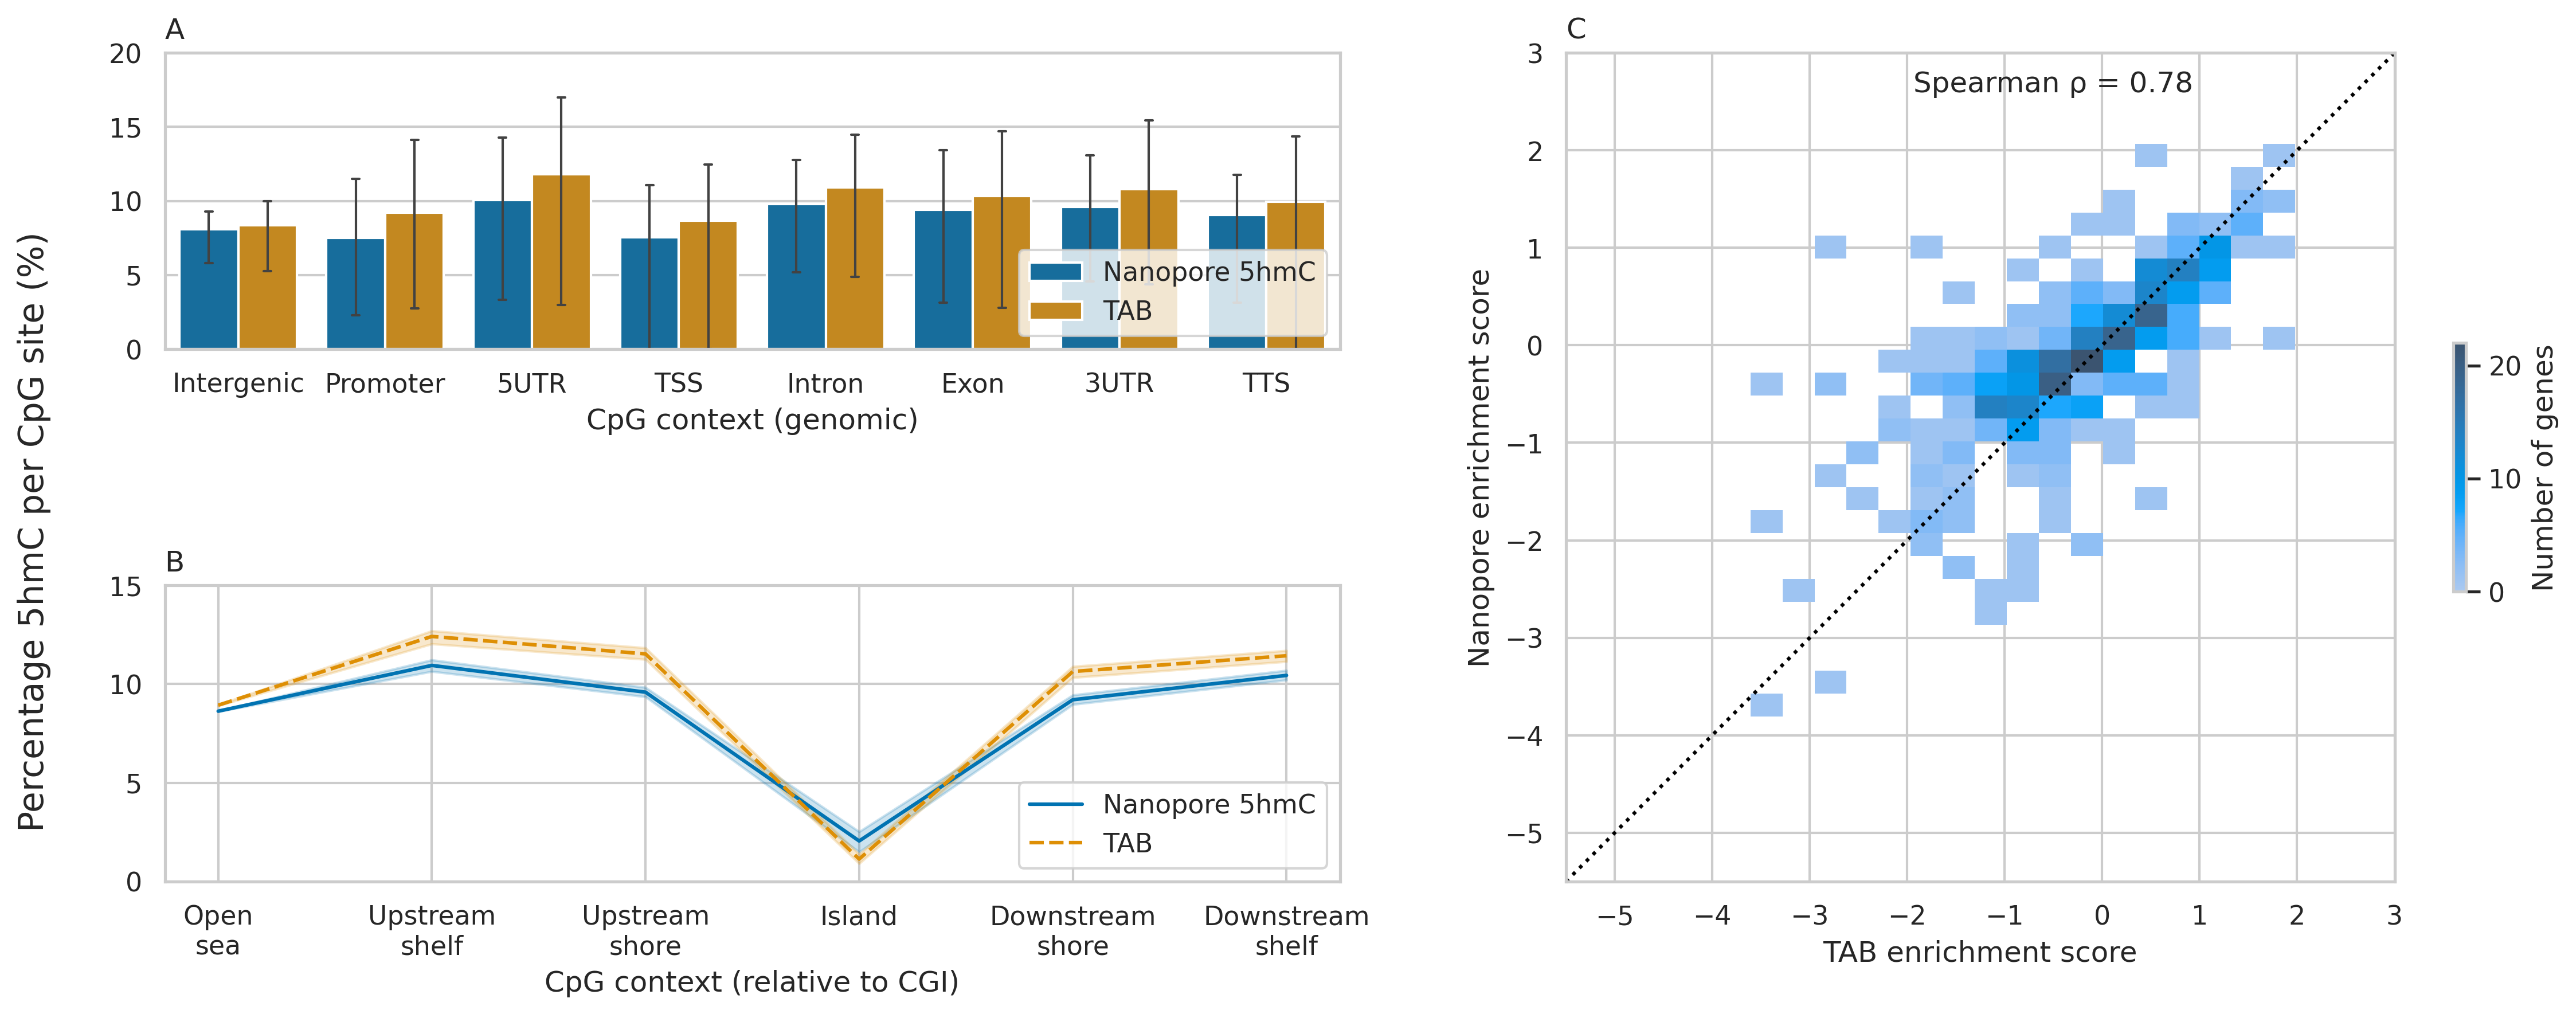

In [124]:
fig3 = plt.figure(dpi=300, figsize=(15, 7))
gs3 = GridSpec(1, 2, fig3)

fig32 = fig3.add_subfigure(gs3[:, 0])
fig32.supylabel("Percentage 5hmC per CpG site (%)", x=-0.07)
gs32 = GridSpec(2, 1, fig32)

ax32 = fig32.add_subplot(gs32[0, :])

sns.barplot(featureBarplot_df, x="feature_type", y="percentMeth", hue="method", capsize=0.05, errorbar=("pi", 50), errwidth=1, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel(None)
ax32.set_ylim((0, 20))
ax32.set_title("A", loc="left")
sns.move_legend(ax32, "lower right", title=None)

ax33 = fig32.add_subplot(gs32[1, :])

sns.lineplot(cgiLinePlot_df, x="feature_type", y="percentMeth", hue="method", style="method", errorbar=("ci", 50), err_style="band", ax=ax33)
ax33.set_xlabel("CpG context (relative to CGI)")
ax33.set_ylabel(None)
ax33.set_ylim((0, 15))
ax33.set_title("B", loc="left")
# ax33.tick_params("x", rotation=10, zorder=10)
ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore", 
                      "Island", "Downstream\nshore", "Downstream\nshelf"])
sns.move_legend(ax33, "lower right", title=None)

fig31 = fig3.add_subfigure(gs3[0, 1])
ax31 = fig31.add_subplot()

sns.histplot(gene_log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d",
                       "shrink" : 0.3},
                       ax=ax31
             )
ax31.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

ax31.set_aspect(1)
ax31.set_ylim((-5.5, 3))
ax31.set_xlim((-5.5, 3))
ax31.set_xlabel("TAB enrichment score")
ax31.set_ylabel("Nanopore enrichment score")
ax31.set_title("C", loc="left")

gene_rho, gene_p = stats.spearmanr(gene_log2_mean_df["Log2FromMean_Nanopore"], gene_log2_mean_df["Log2FromMean_Bisulphite"])
ax31.text(-0.5, 2.6, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")


fig3.tight_layout(pad=4)

# PowerPoint style figures

These figures have been modified for standard PowerPoint dimensions to be used in presentations.

In [78]:
tile_df = tileMain() 
tile_df = tile_df.loc[tile_df["Count"] >= 10] 

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


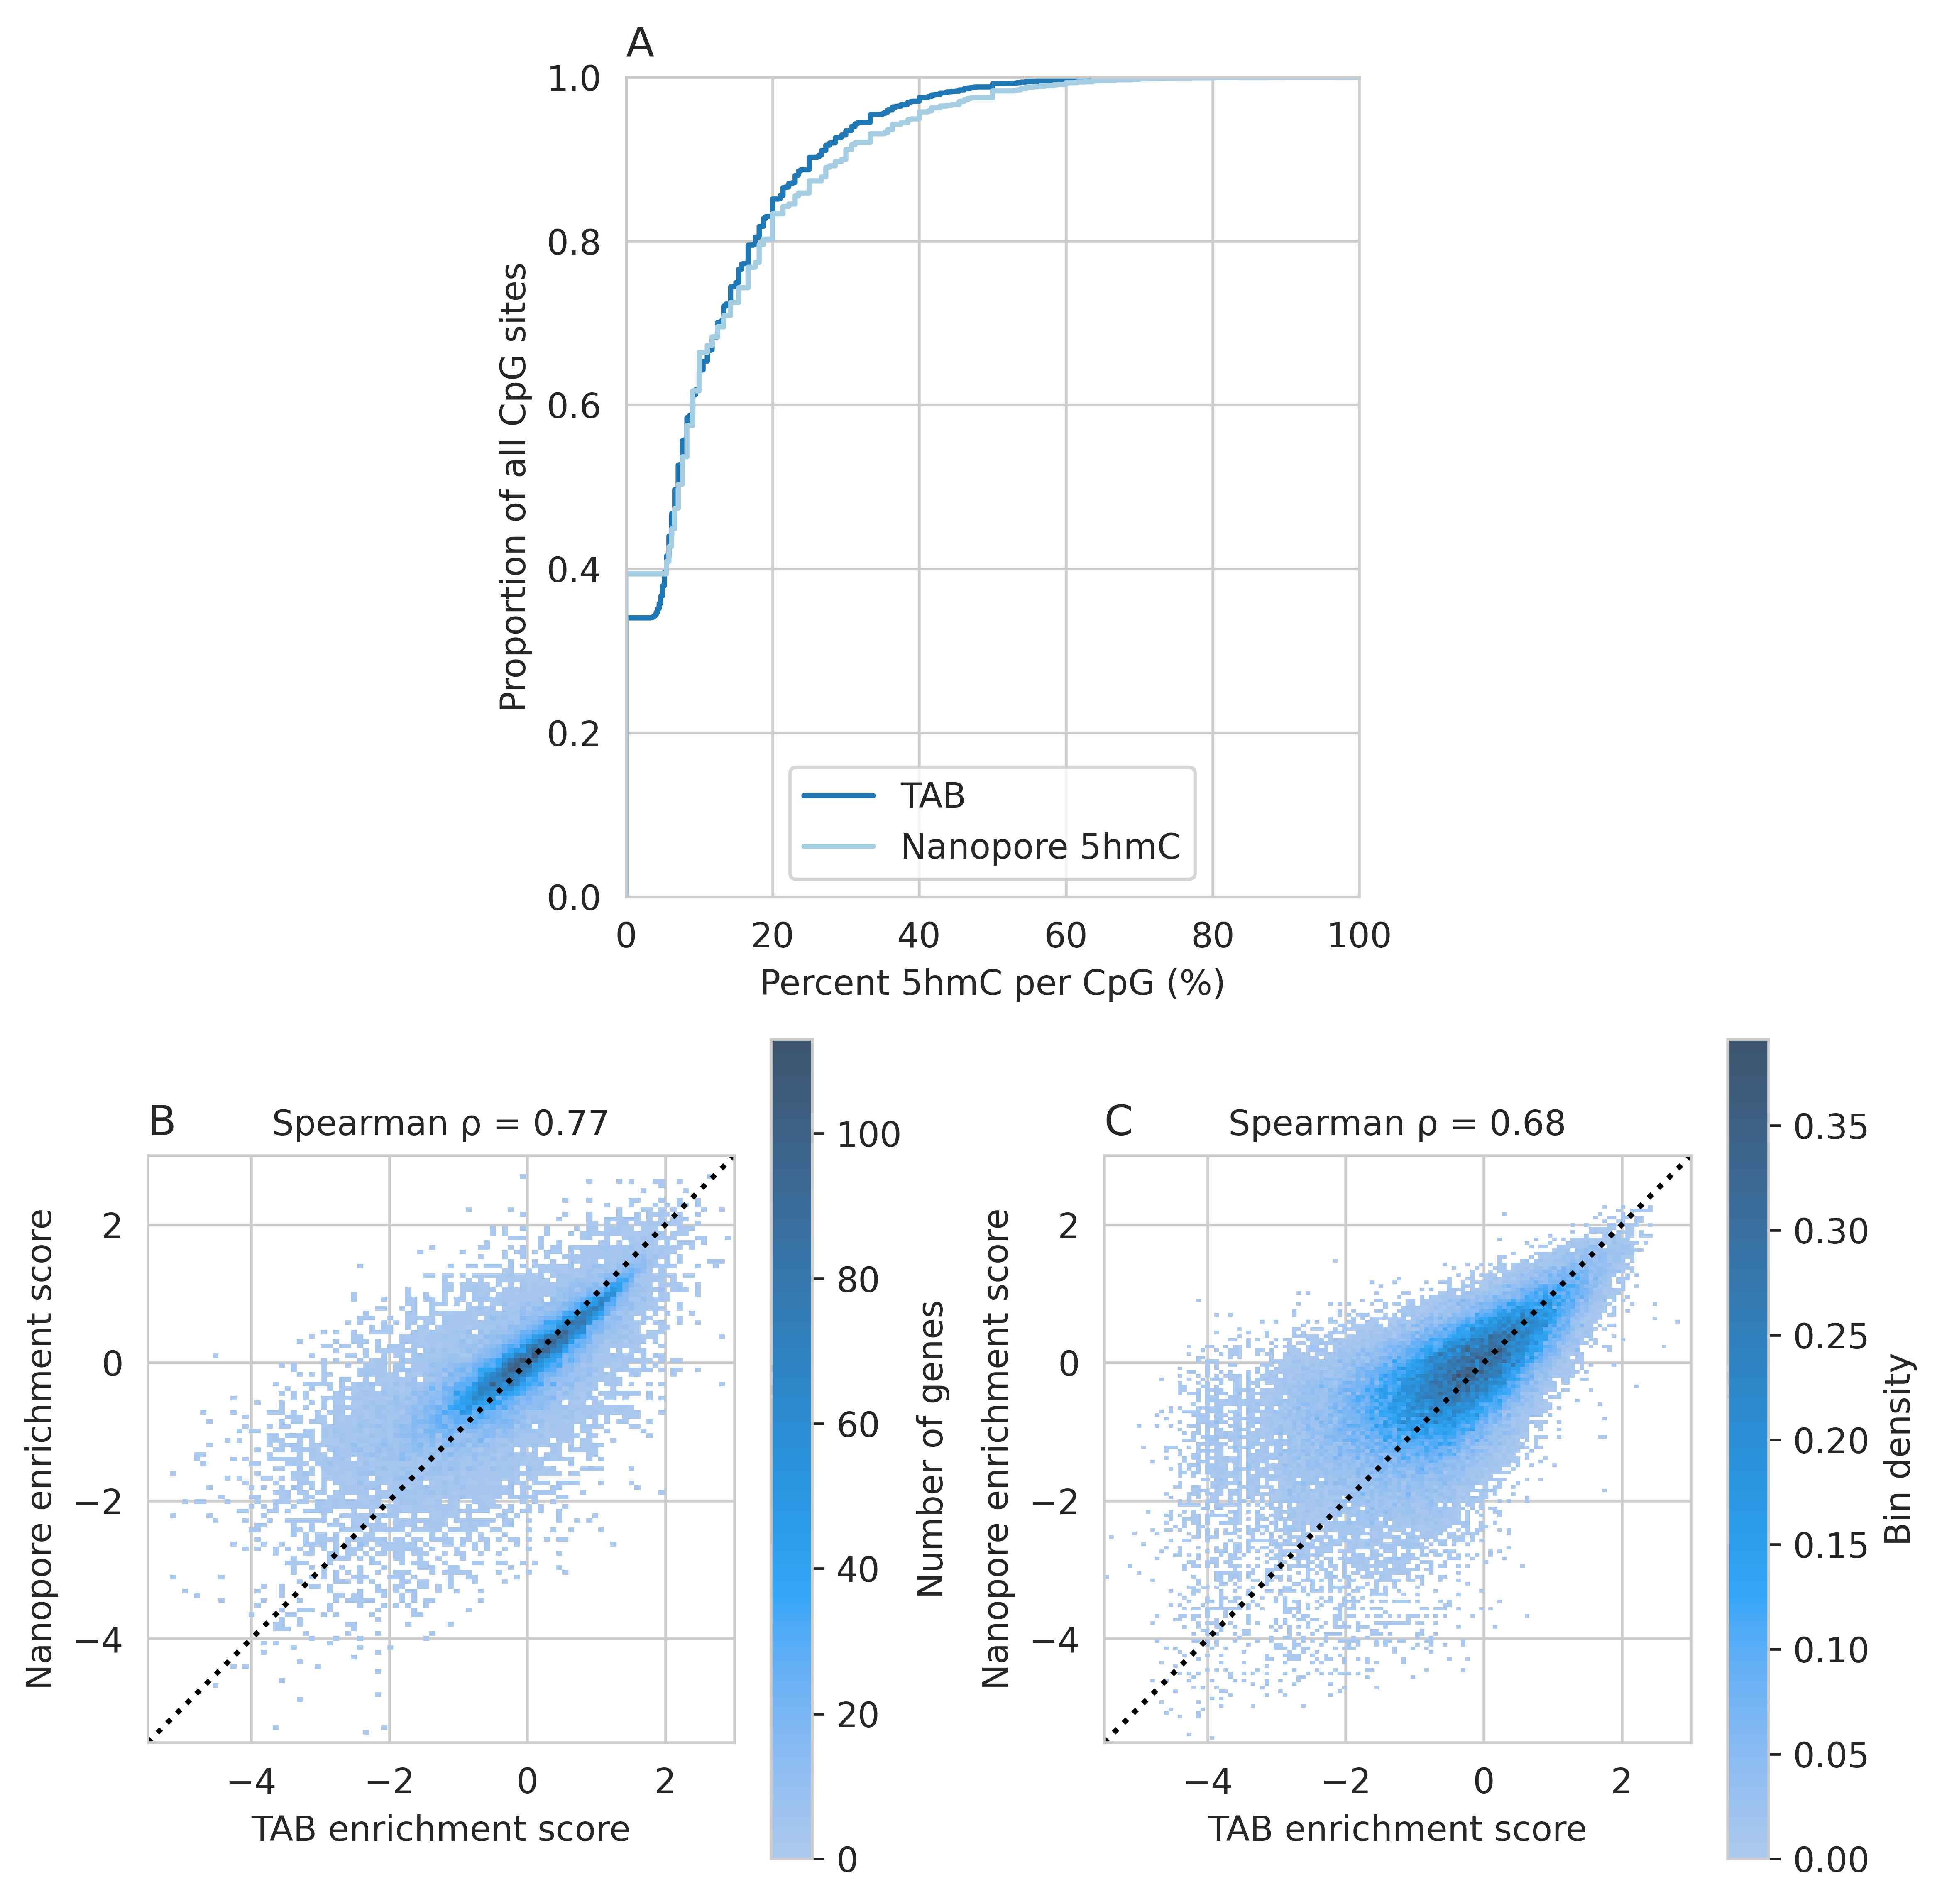

In [82]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=((20)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 4, fig)

ax1 = fig.add_subplot(gs[0, 1:3])
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax1)
sns.move_legend(ax1, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
ax1.set_ylabel("Proportion of all CpG sites")
ax1.set_xlabel("Percent 5hmC per CpG (%)")
ax1.set_xlim([0, 100])
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :2])
ax2.set_aspect("equal", adjustable="box")

sns.histplot(gene_log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d"},
                       ax=ax2)
ax2.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
ax2.set_ylim((-5.5, 3))
ax2.set_xlim((-5.5, 3))

gene_rho, gene_p = stats.spearmanr(gene_log2_mean_df["Log2FromMean_Nanopore"], gene_log2_mean_df["Log2FromMean_Bisulphite"])
ax2.text(3-(5.5+3)/2, 3.3, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")

ax2.set_xlabel("TAB enrichment score")
ax2.set_ylabel("Nanopore enrichment score")
ax2.set_title("B", loc="left")

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_aspect("equal", adjustable="box")

sns.histplot(tile_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="density",
            cbar_kws={"label" : "Bin density"},
            ax=ax3)

tile_rho, tile_p = stats.spearmanr(tile_df["Log2FromMean_Nanopore"], tile_df["Log2FromMean_Bisulphite"])

ax3.text(3-(5.5+3)/2, 3.3, "Spearman \u03C1 = {rho:.2f}".format(rho=tile_rho), ha="center")
ax3.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
ax3.set_title("C", loc="left")
ax3.set_ylim((-5.5, 3))
ax3.set_xlim((-5.5, 3))
ax3.set_xlabel("TAB enrichment score")
ax3.set_ylabel("Nanopore enrichment score")

fig.tight_layout()

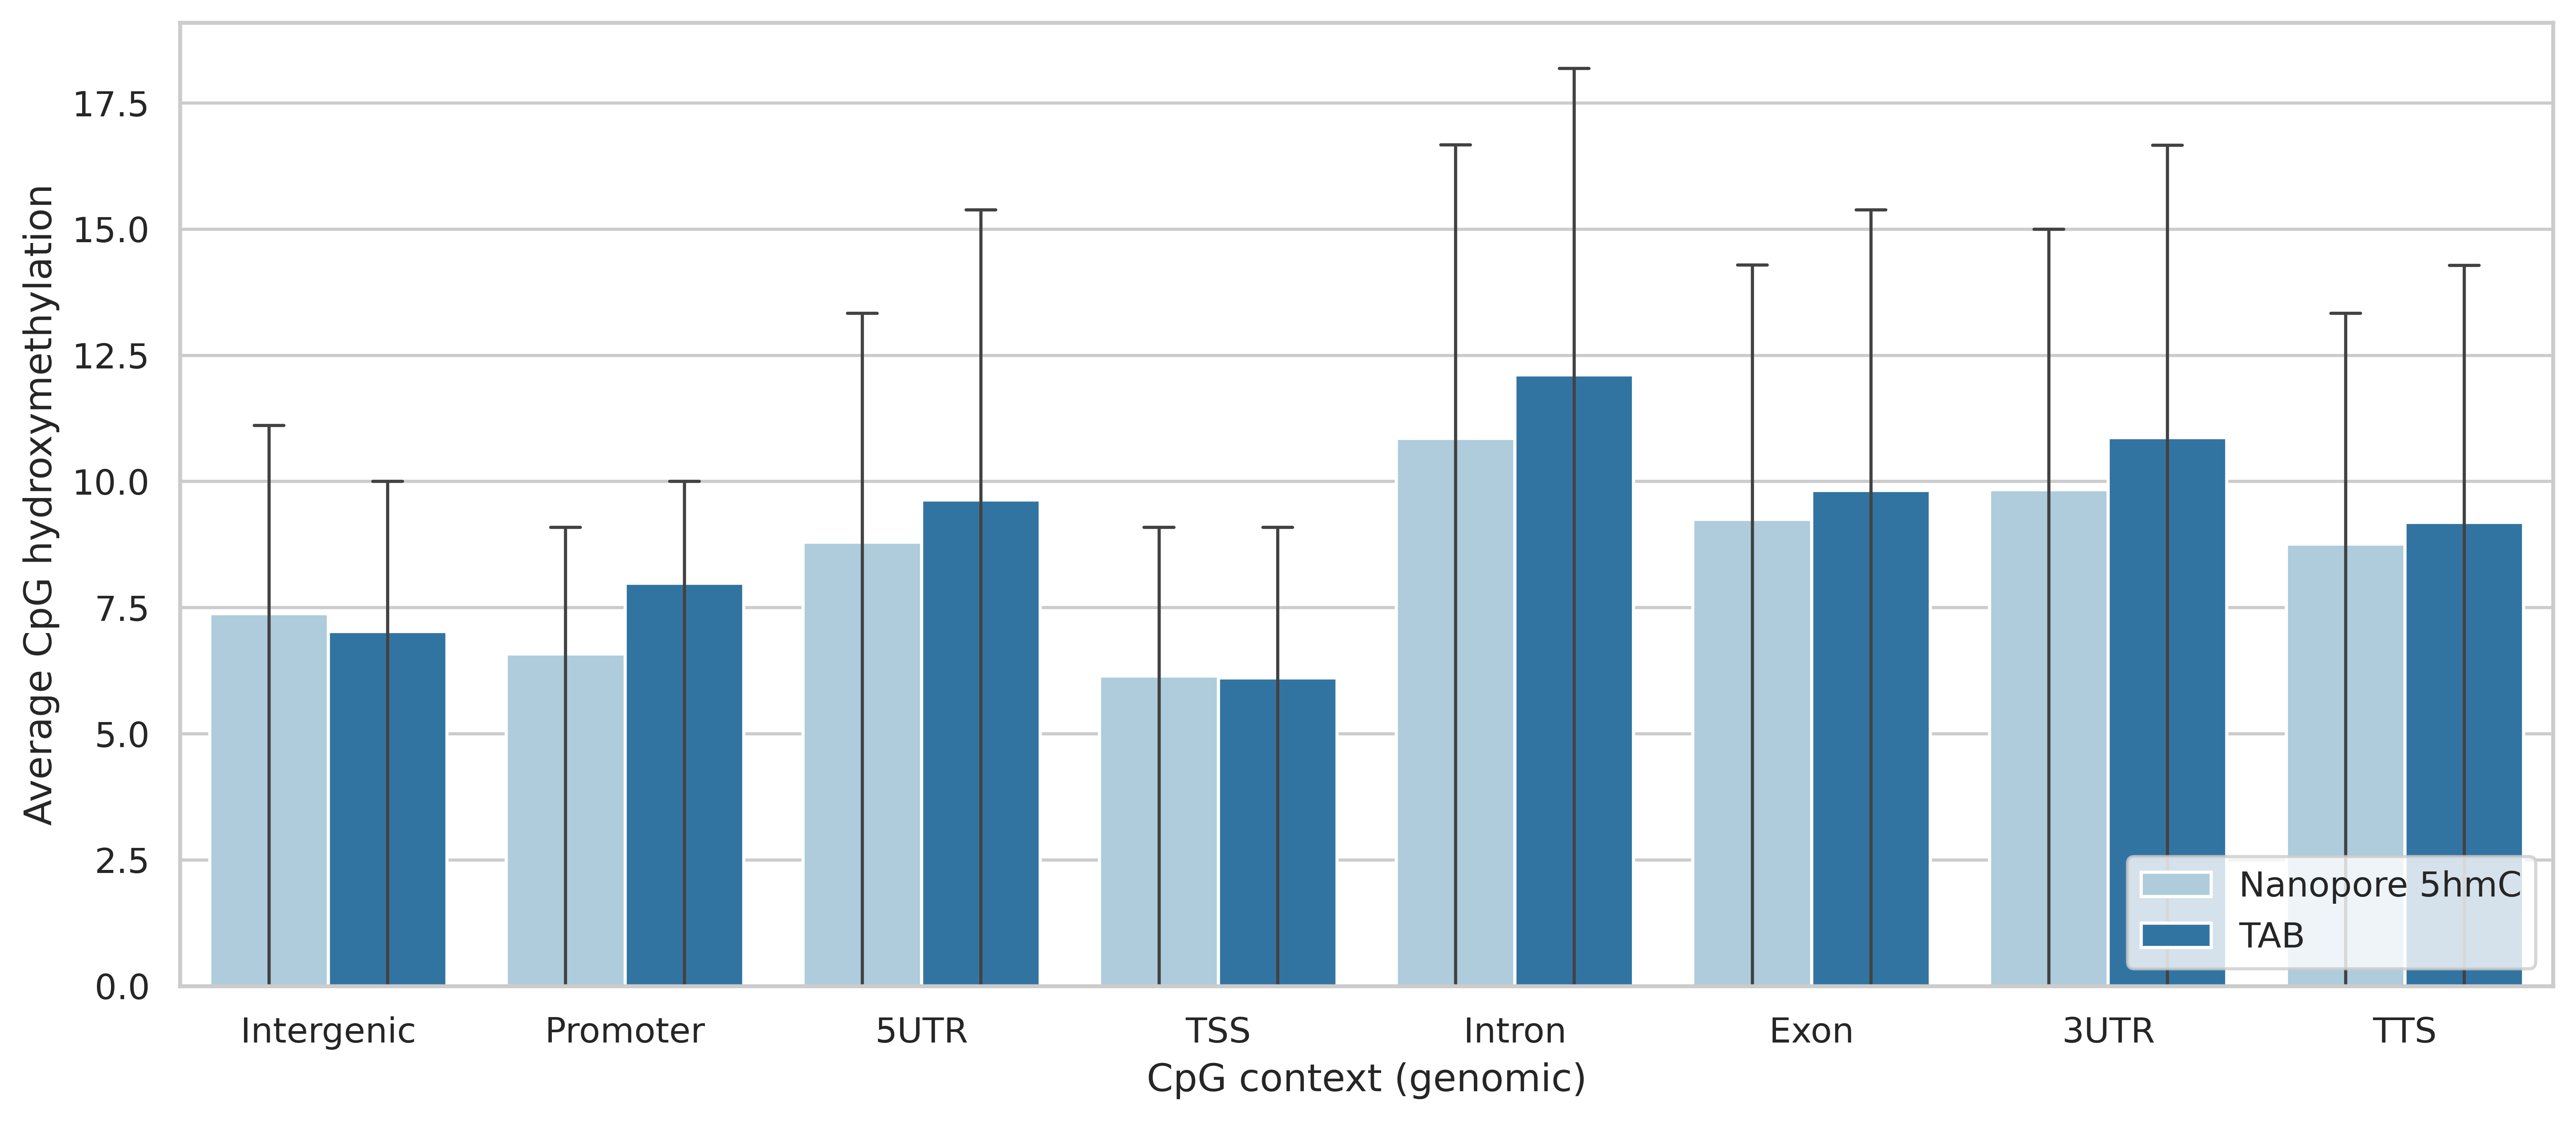

In [142]:
fig = plt.figure(figsize=((29.1)/2.54, (12.9)/2.54), dpi=600, facecolor="None")
gs = GridSpec(1, 1, fig)
sns.set_style("whitegrid")
sns.set_palette("Paired")

ax32 = fig.add_subplot(gs[0, :])

sns.barplot(featureBarplot_df, x="feature_type", y="percentMeth", hue="method", errorbar=("pi", 50), capsize=0.1, errwidth=1, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel("Average CpG hydroxymethylation")
# ax32.set_ylim((0, 40))
sns.move_legend(ax32, "lower right", title=None)    

fig.tight_layout()

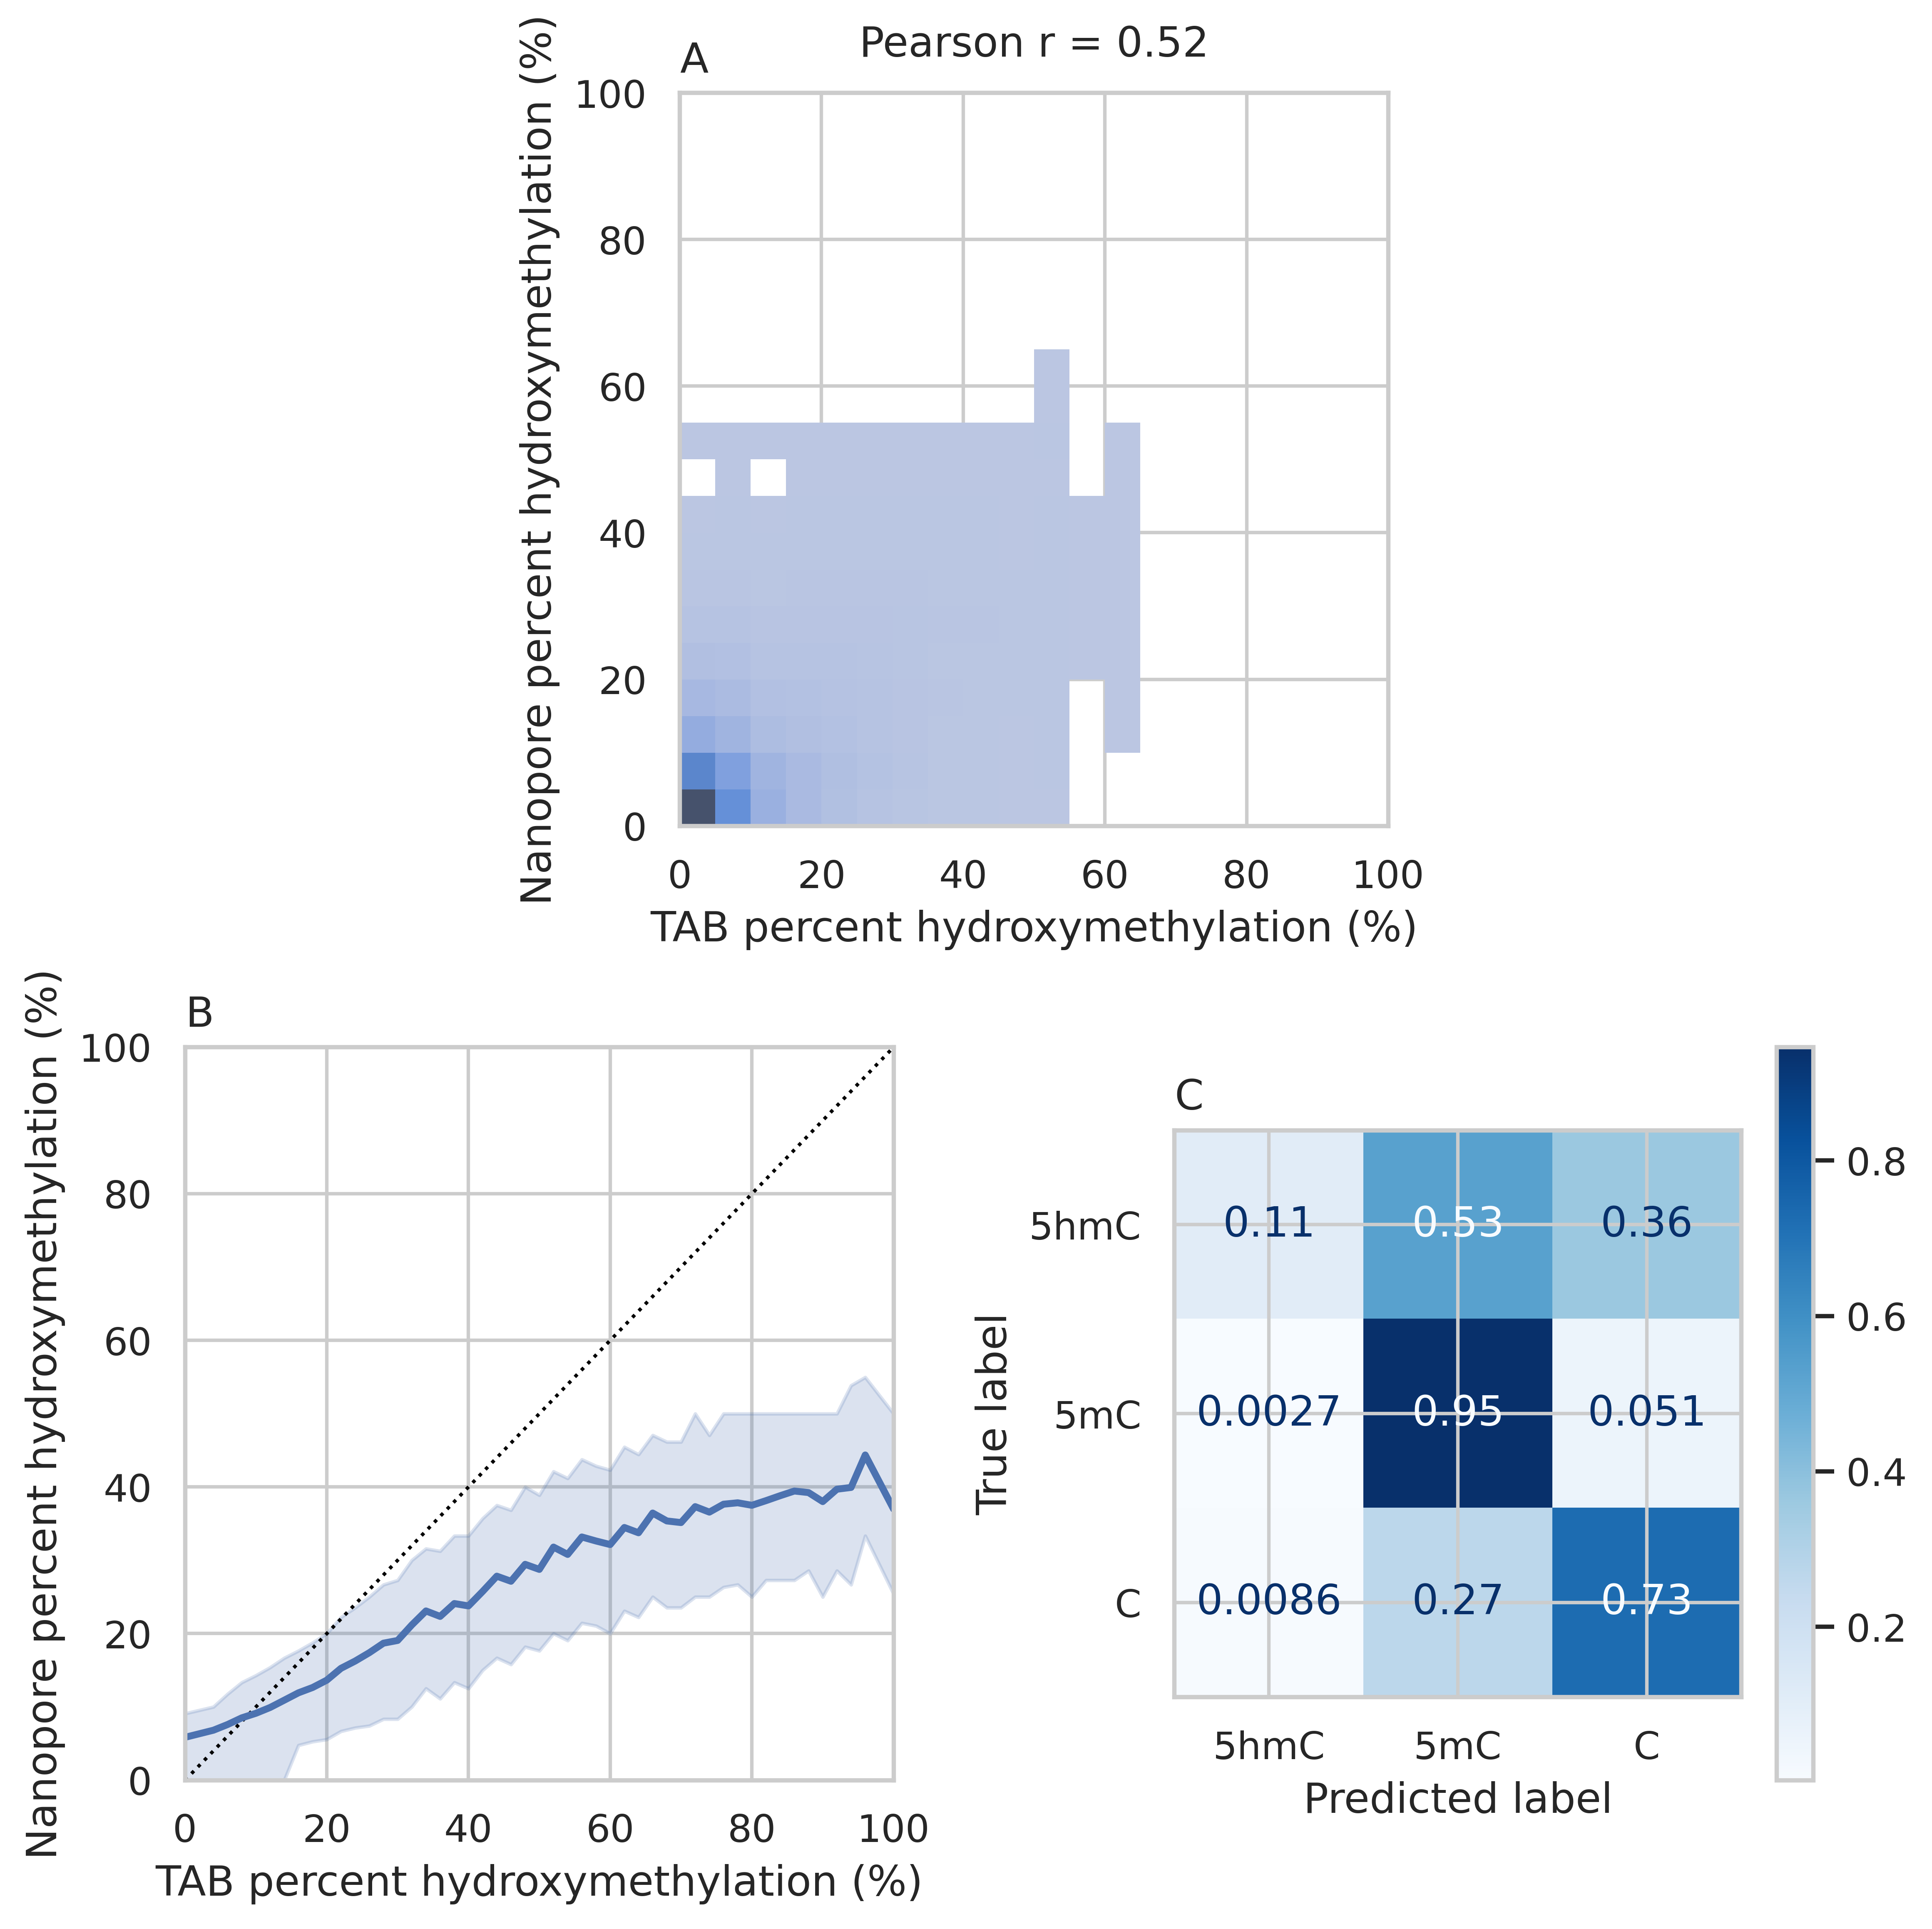

In [130]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=((20)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 4, fig)

ax1 = fig.add_subplot(gs[0, 1:3])
sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax1)
ax1.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax1.set_xlim((0, 100))
ax1.set_ylim((0, 100))
ax1.set_ylabel("Nanopore percent hydroxymethylation (%)")
ax1.set_xlabel("TAB percent hydroxymethylation (%)")
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 50), err_style="band", linewidth=2, ax=ax2)
ax2.set_ylim((0, 100))
ax2.set_xlim((0, 100))
ax2.set_xlabel("TAB percent hydroxymethylation (%)")
ax2.set_ylabel("Nanopore percent hydroxymethylation (%)")
ax2.set_title("B", loc="left")

ax3 = fig.add_subplot(gs[1, 2:])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax3)
ax3.set_title("C", loc="left")

fig.tight_layout()

In [6]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

In [ ]:
# three_mod_pr.to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

# Read level information at imprinted and non-imprinted sites

These scripts extract read level information from the modified bam files and perform clustering based on CpG site methylation states. The resulting clustermaps help to clearly show CpG sites with similar modification status. 

Of note, CpG sites are here aggregated (merged + and - strands) for ease of visualisation. 

In [2]:
from modbampy import ModBam
import pandas as pd
import pyranges as pr
import numpy as np

In [92]:
grb10_pr = pr.PyRanges(chromosomes="chr11", starts=[11878499], ends=[11989420], int64=True) # grb10 used here as an example (start/end coordinates based on mm39)
tiled_grb10_df = grb10_pr.tile(3000).as_df()
tiled_grb10_dict = tiled_grb10_df.to_dict("index")

In [117]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DH_grb10.bam') as bam:
    tile_list = []
    tile_id = 1
    for tile in tiled_grb10_dict.values():
        read_list = []
        for read in bam.reads(tile["Chromosome"], tile["Start"], tile["End"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [tile_id, tile["Chromosome"], tile["Start"], tile["End"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        tile_list.extend(read_list)
        tile_id += 1 
names=["tile", "chromosome", "chromStart", "chromEnd", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
tile_df = pd.DataFrame(tile_list, columns=names)
    
def filterTile(tile): 
    # tile_df.loc[tile_df["refStrand"] == "-", "refPos"] = tile_df["refPos"].sub(2, axis=0)
    one_tile_df = tile_df.loc[(tile_df["tile"] == tile) & (tile_df["refPos"].ge(tile_df["chromStart"])) & (tile_df["refPos"].lt(tile_df["chromEnd"]))] 
    
    tile_df_pivot1 = one_tile_df.pivot(index=["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    tile_df_pivot1["c"] = 255 - tile_df_pivot1[["h", "m"]].sum(axis=1)
    tile_df_melt = pd.melt(tile_df_pivot1, ["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    tile_df_melt = tile_df_melt.loc[tile_df_melt["score"] >= 0.66*255]
    tile_df_melt.loc[tile_df_melt["refStrand"] == "-", "refPos"] = tile_df_melt["refPos"].sub(1, axis=0)

    return tile_df_melt.reset_index(drop=True)

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.50, axis="index") # removes reads with fewer than x% of CpGs
    return new_df

def makeHeatmap(tile):

    data = NADropper(pivotToHeatmap(filterTile(tile)))

    fig = sns.clustermap(data.fillna(-1), 
                mask=data.isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Blues", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    fig.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    fig.ax_cbar.set_xticks([0.33, 1, 1.66])
    fig.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    fig.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    fig.ax_heatmap.set_ylabel("Read")
    fig.ax_heatmap.set_xlabel("CpG position")

    return fig

In [6]:
import numpy as np

def makeTileHeatmaps():
    for tile in np.arange(1, 39, 1):
        fig = makeHeatmap(tile)
        fig.savefig(f'./outputs/Grb10_heatmaps/tile_{tile}_heatmap.png', dpi=600)
        plt.close(fig)
    return 

makeTileHeatmaps()

NameError: name 'makeHeatmap' is not defined